In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from scipy import integrate
from pyqcams import pymar, util, plotters
import pyqcams.constants as constants
import json

In [2]:
# Define system parameters
with open('inputs.json','r') as f:
    data = json.load(f)
m1,m2,m3 = data['masses'].values()
mtot = m1 + m2 + m3
mu12 = m1*m2/(m1+m2) # H2
mu31 = m1*m3/(m1+m3) # CaH
mu32 = m2*m3/(m2+m3) # CaH
mu123 = m3*(m1+m2)/mtot

In [21]:
df = pd.read_csv(f'{path}/fv0j0.csv') # 10000 trajectories per impact parameter
df = df[df['v'] >= 0]
stats = df.iloc[:,:7].groupby(['e','b']).sum()
weights = df.drop(df.iloc[:,9:], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [22]:
# Define weights 
is_cah1 = df['r1'] == 1 
is_cah2 = df['r2'] == 1
is_cah = is_cah1 | is_cah2
cah_w = weights[is_cah].groupby(['e','b','v']).sum()
h2_w = weights[weights['q']==1].groupby(['e','b','v']).sum()
d_w = weights[weights['diss'] == 1].groupby(['e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['e','b']).sum()
net_w['w'] += net_w['diss']

c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'k $(cm^3/s)$')

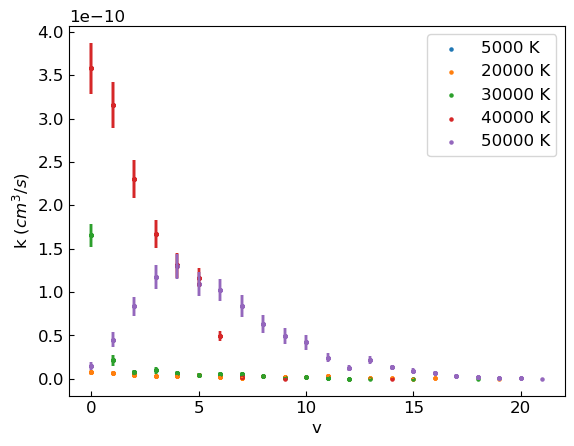

In [23]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['e','b','v']).sum()
cah['p_r'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['perr_r'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index() # Drop dependence on b to integrate
cah.set_index(['e','v'], inplace=True)
cah['s'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah['s_err'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

### Plot rate ###
cah = cah.reset_index()
evals = cah.e.unique()
evals = [5000,20000,30000, 40000,50000]
plt.rcParams.update({'font.size':12})
plt.rc('axes', labelsize = 12)
ax = cah[cah['e']==evals[0]].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{evals[0]} K')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx,e in enumerate(evals[1:]): 
    idx += 1
    cah[cah['e']==e].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{e} K', c = colors[idx], ax=ax)
ax.tick_params(axis = 'x', direction = 'in')
ax.tick_params(axis = 'y', direction = 'in')
# plt.legend(bbox_to_anchor = (1,1))
# plt.yscale('log')
# plt.ylim(10e-19,10e-8)
plt.ylabel('k $(cm^3/s)$')
# plt.title('CaH Formation Rate Distribution ($v_i = 1$)')
# plt.savefig('results/comm_figs/cah_dist_over.svg')


## Inspect the effect of $v_i$ on CaH formation

In [24]:
df0 = pd.read_csv('../QCT/qcams/new_data/v0j0.csv')
df1 = pd.read_csv('../QCT/qcams/new_data/v1j0.csv')
df2 = pd.read_csv('../QCT/qcams/new_data/v2j0.csv')

In [25]:
df = pd.concat([df0,df1,df2])
df = df[df['v'] >= 0]
df = df.set_index('n_i')
stats = df.groupby(['e','b']).sum().loc[:,:'diss']
weights = df.drop(df.loc[:,'d_i':], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [26]:
# Define weights 
is_cah1 = df['cah1'] == 1 
is_cah2 = df['cah2'] == 1
is_cah = is_cah1 | is_cah2 # Combine reaction 1 and reaction 2
cah_w = weights[is_cah].groupby(['n_i','e','b','v']).sum()
h2_w = weights[weights['h2']==1].groupby(['n_i','e','b','v']).sum()
d_w = weights[weights['diss'] == 1].groupby(['n_i','e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['n_i','e','b']).sum()
net_w['w'] += net_w['diss']

In [27]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['n_i','e','b','v']).sum()
cah['p'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['p_err'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index(level = 2) # Drop dependence on b to integrate
# cah.set_index(['n_i','e','v'], inplace=True)
cah['s'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p*g.b, x=g.b))
cah['s_err'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_err*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Rian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'CaH Formation Rate Distribution ($v_i = 0$)')

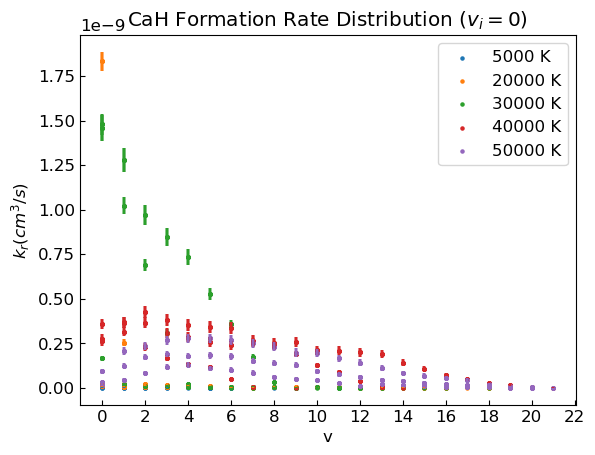

In [30]:
### Plot rate ###
cah = cah.reset_index() 
# cah = cah[cah['b'] == .75]
evals = cah.e.unique()
# evals = [40000]
evals = [5000, 20000, 30000, 40000, 50000]
plt.rcParams.update({'font.size':12})
plt.rc('axes', labelsize = 12)
wich = f'k'
ax = cah[cah['e']==evals[0]].plot.scatter(x='v',y=f'{wich}', yerr = f'{wich}_err', marker ='.', label = f'{evals[0]} K')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx,e in enumerate(evals[1:]): 
    idx += 1
    cah[cah['e']==e].plot.scatter(x='v',y=f'{wich}', yerr = f'{wich}_err', marker ='.', label = f'{e} K', c = colors[idx], ax=ax)
# ax.set_yscale('log')
ax.tick_params(axis = 'x', direction = 'in')
ax.tick_params(axis = 'y', direction = 'in', which = 'both')
plt.xticks(np.arange(0,int(max(cah.v.unique()))+2, 2))
# plt.legend(bbox_to_anchor = (1,1))
# plt.ylim(10e-19,10e-8)
plt.ylabel(f'${wich}_r (cm^3/s)$')
plt.title('CaH Formation Rate Distribution ($v_i = 0$)')

Text(0, 0.5, 'k ($cm^3/s$)')

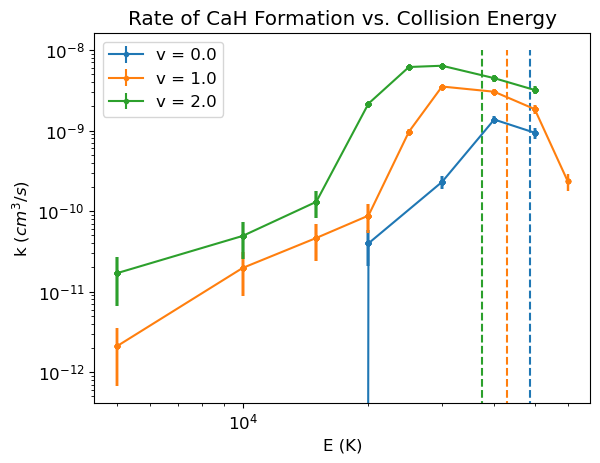

In [37]:
# Calculate P(E,b), sigma(E), k(E) #
# Sum over v's
cah_eb = cah.reset_index().groupby(['n_i','e','b']).sum()
cah_eb = cah_eb.reset_index(level = 2) # Drop dependence on b to integrate
cah_eb['s(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p*g.b, x=g.b))
cah_eb['s_err(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_err*g.b, x=g.b))
cah_eb['k(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s(e)']*constants.autocm**3/constants.ttos
cah_eb['k_err(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s_err(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s_err(e)']*constants.autocm**3/constants.ttos
cah_eb['s(e)'] = cah_eb['s(e)'].drop_duplicates()
cah_eb = cah_eb.reset_index()
elev = cah_eb.n_i.unique()
di = [0.15468234,0.13583315,0.11820821, 0.10180754, 0.08663113] # H2 dissociation energies
ax = cah_eb[cah_eb['n_i']==0].plot(x='e',y='k(e)', yerr= 'k_err(e)', marker = '.', label = f'v = {elev[0]}')
plt.vlines(di[0]/constants.cEK2H, 0, 1e-8, linestyles='dashed')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for idx,v in enumerate(elev[1:]):
    idx += 1
    cah_eb[cah_eb['n_i']==v].plot(x = 'e', y = 'k(e)', yerr = 'k_err(e)', marker = '.', label = f'v = {v}', color = colors[idx], ax=ax)
    plt.vlines(di[idx]/constants.cEK2H, 0, 1e-8, linestyles='dashed', color = colors[idx])
plt.xscale('log')
plt.yscale('log')
plt.title('Rate of CaH Formation vs. Collision Energy')
plt.xlabel('E (K)')
plt.ylabel('k ($cm^3/s$)')

Blue vertical line at E = 20000 K is not the errorbar corresponding to the datapoint; need to fix. 